# Consensus Mouse: 10X gene expression

In the [previous notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/consensus_mouse_clustering_analysis_and_annotation.html), we explored the taxonomy and combined it with cell level and other metadata. In this notebook, we load and explore gene expression data, loading the expression of specific genes. We plot these expressions in the heatmaps, comparing the expression across the taxonomy and parcellation region, as well as show the gene expression in the UMAP.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Optional

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache
from abc_atlas_access.abc_atlas_cache.anndata_utils import get_gene_data

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requested data on disk. For metadata, the cache can also directly serve up a Pandas DataFrame. See the [``getting_started``](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html) notebook for more details on using the cache including installing it if it has not already been. 

**Change the download_base variable to where you would like to download the data to your system.**

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(
    download_base,
    s3_bucket='allen-brain-cell-atlas-staging',
    auth_required=True
)

abc_cache.current_manifest

'releases/20251031/manifest.json'

Below we create the expanded cell metadata as was done previously in the [cluster annotation tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/consensus_mouse_clustering_analysis_and_annotation.html) tutorial.

In [ ]:
cell_to_cluster_membership = abc_cache.get_metadata_dataframe(
    'Consensus-Mouse-taxonomy', 'cell_to_cluster_membership'
).set_index('cell_label')
cluster = abc_cache.get_metadata_dataframe(
    'Consensus-Mouse-taxonomy', 'cluster'
).set_index('label')
cluster_annotation_term = abc_cache.get_metadata_dataframe(
    'Consensus-Mouse-taxonomy', 'cluster_annotation_term'
).set_index('label')

cluster_annotation_term_set = abc_cache.get_metadata_dataframe(
    directory='Consensus-Mouse-taxonomy',
    file_name='cluster_annotation_term_set'
).set_index('label')

cluster_to_cluster_annotation_membership = abc_cache.get_metadata_dataframe(
    directory='Consensus-Mouse-taxonomy',
    file_name='cluster_to_cluster_annotation_membership'
).set_index('cluster_annotation_term_label')

macosko_cell_metadata = abc_cache.get_metadata_dataframe('Consensus-Mouse-Macosko-10X', 'cell_metadata').set_index('cell_label')
wmb_cell_metadata = abc_cache.get_metadata_dataframe('Consensus-Mouse-WMB-10X', 'cell_metadata').set_index('cell_label')

membership_with_cluster_info = cluster_to_cluster_annotation_membership.join(
    cluster.reset_index().set_index('cluster_alias')[['number_of_cells']],
    on='cluster_alias'
)

membership_with_cluster_info = membership_with_cluster_info.join(cluster_annotation_term, rsuffix='_anno_term').reset_index()

membership_groupby = membership_with_cluster_info.groupby(
    ['cluster_alias', 'cluster_annotation_term_set_name']
)

cluster_details = membership_groupby['cluster_annotation_term_name'].first().unstack()
cluster_order = membership_groupby['term_order'].first().unstack()
cluster_order.sort_values(['neighborhood', 'class', 'subclass', 'supertype', 'cluster'], inplace=True)

cluster_colors = membership_groupby['color_hex_triplet'].first().unstack()
cluster_colors = cluster_colors[cluster_annotation_term_set['name']]
cluster_colors.sort_values(
    ['neighborhood', 'class', 'subclass', 'supertype', 'cluster'],
    inplace=True
)

wmb_cell_extended = wmb_cell_metadata.join(cell_to_cluster_membership, how='inner')
wmb_cell_extended = wmb_cell_extended.join(cluster_details, on='cluster_alias')
wmb_cell_extended = wmb_cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
wmb_cell_extended = wmb_cell_extended.join(cluster_order, on='cluster_alias', rsuffix='_order')

wmb_library = abc_cache.get_metadata_dataframe(
    directory='Consensus-Mouse-WMB-10X',
    file_name='library'
).set_index('library_label')
wmb_donor = abc_cache.get_metadata_dataframe(
    directory='Consensus-Mouse-WMB-10X',
    file_name='donor'
).set_index('donor_label')
wmb_cell_extended = wmb_cell_extended.join(wmb_library, on='library_label')
wmb_cell_extended = wmb_cell_extended.join(wmb_donor, on='donor_label')

macosko_cell_extended = macosko_cell_metadata.join(cell_to_cluster_membership, how='inner')
macosko_cell_extended = macosko_cell_extended.join(cluster_details, on='cluster_alias')
macosko_cell_extended = macosko_cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
macosko_cell_extended = macosko_cell_extended.join(cluster_order, on='cluster_alias', rsuffix='_order')

macosko_library = abc_cache.get_metadata_dataframe(
    directory='Consensus-Mouse-Macosko-10X',
    file_name='library'
).set_index('library_label')
macosko_donor = abc_cache.get_metadata_dataframe(
    directory='Consensus-Mouse-Macosko-10X',
    file_name='donor'
).set_index('donor_label')
macosko_cell_extended = macosko_cell_extended.join(macosko_library, on='library_label')
macosko_cell_extended = macosko_cell_extended.join(macosko_donor, on='donor_label')

cluster_alias
cell_label                                                  
CAGGTGCAGGCTAGCA-040_C01                                5491
CGGACGTGTGTGAATA-063_B01                                6268
GATCCCTTCGTGCACG-107_B01                                6659
TCACGAACAACTGCGC-026_A01                                6672
ACACCAAGTCAAACTC-026_B01                                7067
...                                                      ...
pBICCNsMMrTHT6iM018d210407A2_TAGACTGGTCCCTGAG          10945
pBICCNsMMrTHT8iF019d210409A1_AACAGGGGTAACAAGT          10945
pBICCNsMMrTHT5iF019d210408A1_AAAGGGCAGCTGAGTG          10903
pBICCNsMMrTHT5iF019d210408A1_AGTGACTTCCGTGACG          10808
pBICCNsMMrTHT5iF016d210330A1_AGCGTCGTCATAGAGA          10903

[7651713 rows x 1 columns]

### Single cell transcriptomes

Below we use the convenience function `get_gene_data` to download and extract specific genes from the gene expression h5ad files. This function can be used to pull expression for the full set of cells or any subset from the set of cell metadata.

We first load the gene data for the WMB portion of the consensus dataset.

In [20]:
wmb_gene = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='gene'
).set_index('gene_identifier')
print("Number of aligned genes = ", len(wmb_gene))
wmb_gene.head(5)

Number of aligned genes =  32285


gene_symbol                               name  \
gene_identifier                                                     
ENSMUSG00000051951        Xkr4  X-linked Kx blood group related 4   
ENSMUSG00000089699      Gm1992                predicted gene 1992   
ENSMUSG00000102331     Gm19938              predicted gene, 19938   
ENSMUSG00000102343     Gm37381              predicted gene, 37381   
ENSMUSG00000025900         Rp1     retinitis pigmentosa 1 (human)   

                   mapped_ncbi_identifier comment  
gene_identifier                                    
ENSMUSG00000051951        NCBIGene:497097     NaN  
ENSMUSG00000089699                    NaN     NaN  
ENSMUSG00000102331                    NaN     NaN  
ENSMUSG00000102343                    NaN     NaN  
ENSMUSG00000025900         NCBIGene:19888     NaN

Next we load the same metadata for the Macosko data. Note that the two samples have slightly different sets of genes, however, they have a large overlap. 

In [21]:
macosko_gene = abc_cache.get_metadata_dataframe(
    directory='Consensus-Mouse-Macosko-10X',
    file_name='gene'
).set_index('gene_identifier')
print("Number of aligned genes = ", len(macosko_gene))
macosko_gene.head(5)

Number of aligned genes =  21205


gene_symbol
gene_identifier               
ENSMUSG00000072572     Slc39a2
ENSMUSG00000063179        Pstk
ENSMUSG00000041220      Elovl6
ENSMUSG00000042246        Tmc7
ENSMUSG00000075072      Olfr48

Below we list the genes we will use in this notebook and the example method used to load the expression for these specific genes from the h5ad file. Note that we provide a set of example gene expressions as a csv file for brevity in this tutorial. To process and extract the gene expressions for yourself, uncomment the code block below. More details on how to extract specific genes from the data see our [accessing gene expression data tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/general_accessing_10x_snRNASeq_tutorial.html)

In [ ]:
gene_names = ['Slc17a7', 'Slc17a6', 'Slc17a8', 'Slc32a1', 'Slc6a5', 'Slc18a3', 'Slc6a3', 'Slc6a4', 'Slc6a2']

wmb_gene_data = get_gene_data(
    abc_atlas_cache=abc_cache,
    all_cells=wmb_cell_metadata,
    all_genes=wmb_gene,
    selected_genes=gene_names
)

loading file: WMB-10Xv2-CTXsp
 - time taken:  8.144787
loading file: WMB-10Xv2-HPF


WMB-10Xv2-HPF-log2.h5ad: 100%|██████████| 6.10G/6.10G [28:51<00:00, 3.52MMB/s]    


 - time taken:  43.59536099999997
loading file: WMB-10Xv2-HY


WMB-10Xv2-HY-log2.h5ad: 100%|██████████| 2.91G/2.91G [13:16<00:00, 3.65MMB/s]    


 - time taken:  21.82093900000001
loading file: WMB-10Xv2-Isocortex-1


WMB-10Xv2-Isocortex-1-log2.h5ad: 100%|██████████| 8.60G/8.60G [44:35<00:00, 3.21MMB/s]    


 - time taken:  51.835064999999986
loading file: WMB-10Xv2-Isocortex-2


WMB-10Xv2-Isocortex-2-log2.h5ad:  17%|█▋        | 1.62G/9.44G [07:16<41:37, 3.13MMB/s]    

In [ ]:
macosko_gene_data = get_gene_data(
    abc_atlas_cache=abc_cache,
    all_cells=macosko_cell_metadata,
    all_genes=macosko_gene,
    selected_genes=gene_names
)

loading file: Macosko-10X-CB
 - time taken:  116.73798833599994
loading file: Macosko-10X-HPF
 - time taken:  99.99523630800013
loading file: Macosko-10X-HY
 - time taken:  28.24416544399992
loading file: Macosko-10X-Isocortex
 - time taken:  243.23255124799994
loading file: Macosko-10X-MB
 - time taken:  182.9963331150002
loading file: Macosko-10X-MY-Pons-BS
 - time taken:  187.8848094030002
loading file: Macosko-10X-OLF
 - time taken:  45.21619240900009
loading file: Macosko-10X-PAL
 - time taken:  59.825528361000124
loading file: Macosko-10X-STR
 - time taken:  43.186921289999646
loading file: Macosko-10X-TH
 - time taken:  98.16450259200019
total time taken: 1105.491693631
	total cells: 3736281 processed cells: 3736281


Instead of processing the gene expressions, we load a pre-processed file.

We load merge the expression into each of our cell metadata.

In [ ]:
wmb_cell_extended = wmb_cell_extended.join(wmb_gene_data)
macosko_cell_extended = macosko_cell_extended.join(macosko_gene_data)

ValueError: columns overlap but no suffix specified: Index(['Slc32a1', 'Slc17a7', 'Slc6a5', 'Slc17a6', 'Slc6a2', 'Slc17a8',
       'Slc6a4', 'Slc6a3', 'Slc18a3'],
      dtype='object')

## Example use cases

In this section, we show a use case plotting a set of genes that map onto a cononical set of neurotransmitters. These are the same set genes used in the [WMB tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/10x_snRNASeq_tutorial_part_2b.html).

The helper function below creates a heatmap showing the relation between various parameters in the combined cell metadata and the genes we loaded.

In [ ]:
import matplotlib as mpl

def plot_heatmap(
    df: pd.DataFrame,
    gnames: List[str],
    value: str,
    sort: bool = False,
    fig_width: float = 8,
    fig_height: float = 4,
    vmax: float = None,
    cmap: plt.cm = plt.cm.magma_r
):
    """Plot a heatmap of gene expression values for a list of genes across species.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cell metadata and gene expression values.
    gnames : list
        List of gene names to plot.
    value : str
        Column name in df to group by (e.g., 'species_genus').
    sort : bool, optional
        Whether to sort the gene expression values within each species.
    fig_width : float, optional
        Width of the figure in inches.
    fig_height : float, optional
        Height of the figure in inches.
    vmax : float, optional
        Maximum value for the color scale. If None, it is set to the maximum value in the data.
    cmap : matplotlib colormap, optional
        Colormap to use for the heatmap.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object containing the heatmap.
    ax : array of matplotlib.axes.Axes
        The axes objects for each species.
    """

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(fig_width, fig_height)

    grouped = df.groupby(value)[gnames].mean()
    vmin = grouped.min().min()
    vmax = grouped.max().max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cmap = sm.get_cmap()

    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
        grouped = grouped.loc[sorted(grouped.index)]

    arr = grouped.to_numpy().astype('float')

    ax.imshow(arr, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    xlabs = grouped.columns.values
    ylabs = grouped.index.values


    ax.set_yticks(range(len(ylabs)))
    ax.set_yticklabels(ylabs)
    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.01, pad=0.01)
    cbar.set_label('Mean Expression [log2(CPM + 1)]')
    plt.subplots_adjust(wspace=0.00, hspace=0.00)
    
    return fig, ax

### Expression of selected genes



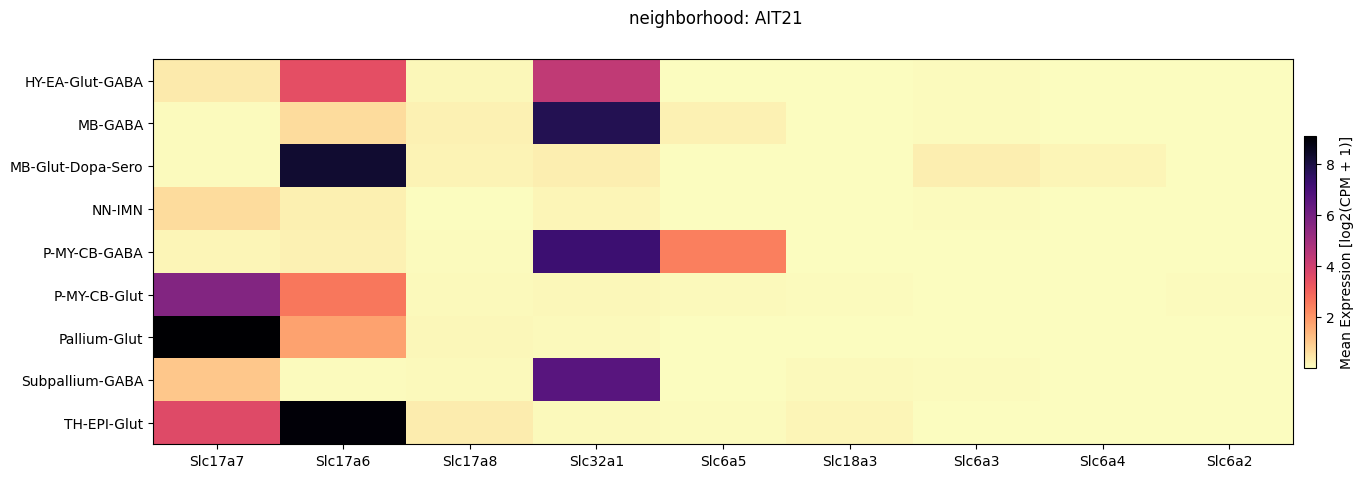

In [ ]:
fig, ax = plot_heatmap(
    df=wmb_cell_extended,
    gnames=gene_names,
    value='neighborhood',
    fig_width=15,
    fig_height=5,
    sort=True
)
fig.suptitle('neighborhood: AIT21')
plt.show()

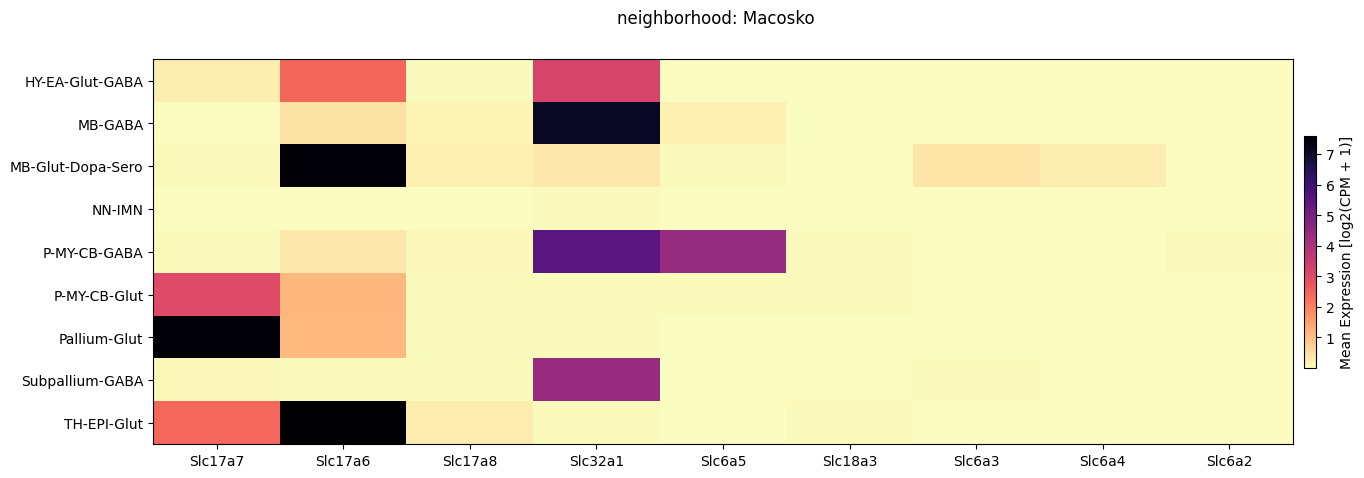

In [ ]:
fig, ax = plot_heatmap(
    df=macosko_cell_extended,
    gnames=gene_names,
    value='neighborhood',
    fig_width=15,
    fig_height=5,
    sort=True
)
fig.suptitle('neighborhood: Macosko')
plt.show()

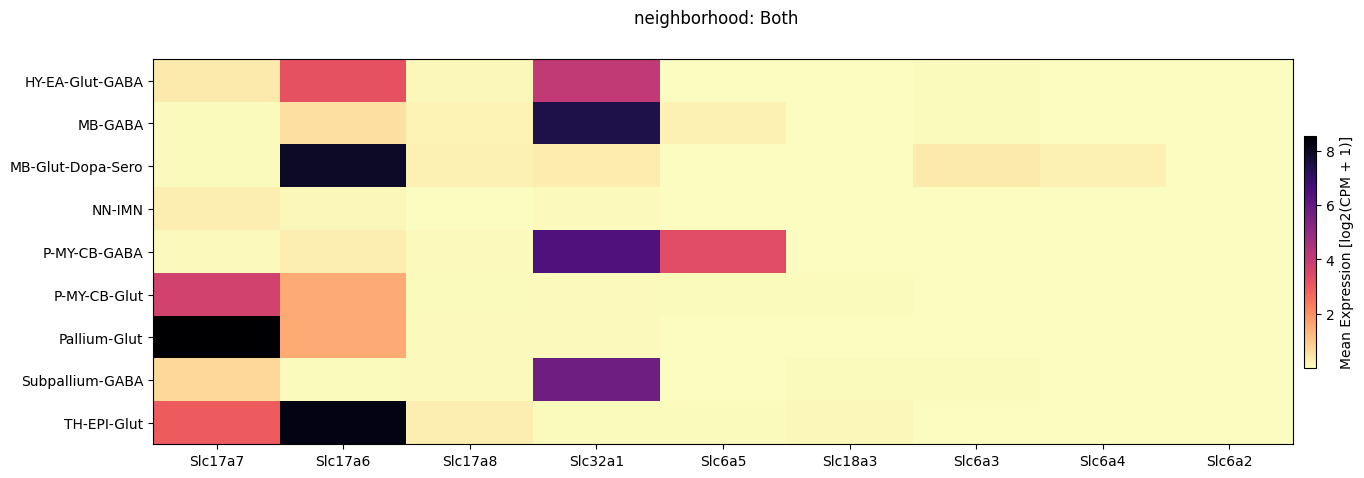

In [ ]:
fig, ax = plot_heatmap(
    df=pd.concat([wmb_cell_extended, macosko_cell_extended]),
    gnames=gene_names,
    value='neighborhood',
    fig_width=15,
    fig_height=5,
    sort=True
)
fig.suptitle('neighborhood: Both')
plt.show()

In [ ]:
fig, ax = plot_heatmap(
    df=pd.concat([wmb_cell_extended, macosko_cell_extended]),
    gnames=gene_names,
    value='neurotransmitter',
    fig_width=15,
    fig_height=5,
    sort=True
)
fig.suptitle('Neurotransmitter: Both')
plt.show()

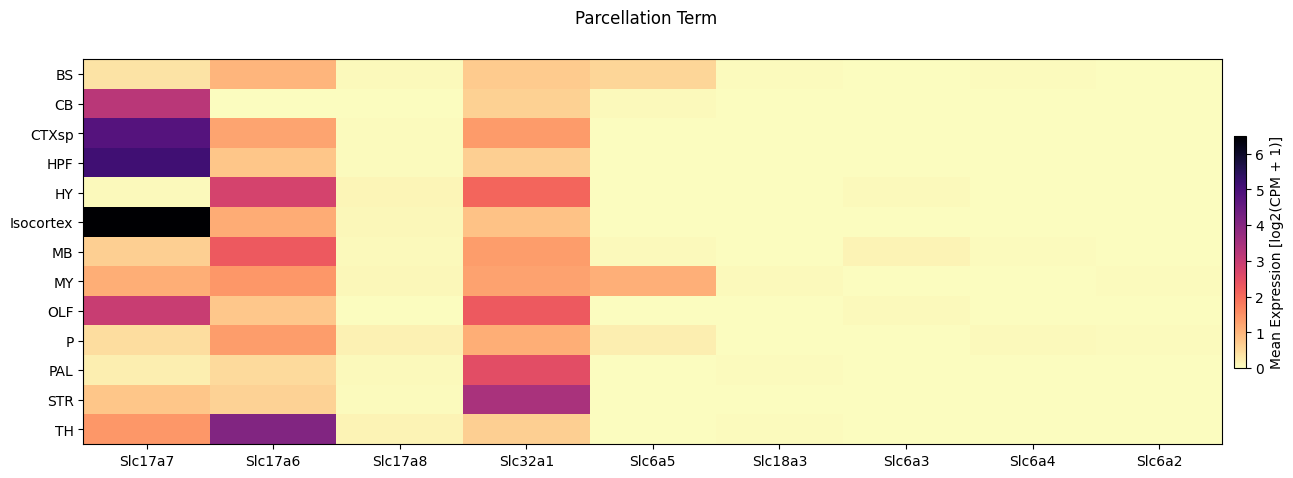

In [ ]:
fig, ax = plot_heatmap(
    df=pd.concat([wmb_cell_extended, macosko_cell_extended]),
    gnames=gene_names,
    value='parcellation_term_symbol',
    fig_width=15,
    fig_height=5,
    sort=True
)
fig.suptitle('Parcellation Term')
plt.show()

## Expression in the UMAP

In [ ]:
pal_glut_umap = pd.read_csv(
    '/allen/programs/celltypes/workgroups/rnaseqanalysis/chris.morrison/consenus_mouse/metadata/consensus_pal_glut_umap.csv'
).set_index('cell_label')
pal_glut_umap

x          y
cell_label                                                        
GCGAGAAGTTAAGGGC-410_B05                      10.979857  -0.701897
AATGGCTCAGCTCCTT-411_B06                      10.953382  -0.705625
AACACACGTTGCTTGA-410_B05                      10.967798  -0.543428
CACAGATAGAGGCGGA-410_A05                      11.065583  -0.739276
GATCGTATCGAATCCA-411_B06                      10.950531  -0.817459
...                                                 ...        ...
pBICCNsMMrOLFiM016d201201D3_ACGTCCTAGAGTGACC  -2.606975  11.342708
pBICCNsMMrOLFiM016d201201D3_ATTATCCCAACTCCAA  -2.670466  11.603328
pBICCNsMMrENTiM017d210119B2_CTGTGGGAGCACCAGA   6.851151  10.507414
pBICCNsMMrAUDiF022d210715A5_TCATTACCATCGTGGC   9.265067   8.984301
pBICCNsMMrENTiM017d210119B2_CCCTCAAAGCACCGAA  -5.186678   4.518539

[2179891 rows x 2 columns]

In [ ]:
consensus_pal_glut_umap = pd.concat([wmb_cell_extended, macosko_cell_extended]).join(pal_glut_umap)
consensus_pal_glut_umap

cell_barcode  \
cell_label                                                             
GCGAGAAGTTAAGGGC-410_B05                            GCGAGAAGTTAAGGGC   
AATGGCTCAGCTCCTT-411_B06                            AATGGCTCAGCTCCTT   
AACACACGTTGCTTGA-410_B05                            AACACACGTTGCTTGA   
CACAGATAGAGGCGGA-410_A05                            CACAGATAGAGGCGGA   
GATCGTATCGAATCCA-411_B06                            GATCGTATCGAATCCA   
...                                                              ...   
pBICCNsMMrHPFCA2CA3iF014d210217A2_TTACTGTTCCCAAGCG  TTACTGTTCCCAAGCG   
pBICCNsMMrHPFCA2CA3iF014d210217A2_TTGGGTAGTTGGTACT  TTGGGTAGTTGGTACT   
pBICCNsMMrHPFCA2CA3iF014d210217A2_ACGGTCGCAAAGGCGT  ACGGTCGCAAAGGCGT   
pBICCNsMMrHPFCA2CA3iF014d210217A2_TGAACGTCATGTAACC  TGAACGTCATGTAACC   
pBICCNsMMrHPFCA2CA3iF014d210217A2_ATCGTGAGTACTGCGC  ATCGTGAGTACTGCGC   

                                                   barcoded_cell_sample_label  \
cell_label                                                                      
GCGAGAAGTTAAGGGC-410_B05                                              410_B05   
AATGGCTCAGCTCCTT-411_B06                                              411_B06   
AACACACGTTGCTTGA-410_B05                                              410_B05   
CACAGATAGAGGCGGA-410_A05                                              410_A05   
GATCGTATCGAATCCA-411_B06                                              411_B06   
...                                                                       ...   
pBICCNsMMrHPFCA2CA3iF014d210217A2_TTACTGTTCCCAAGCG                        NaN   
pBICCNsMMrHPFCA2CA3iF014d210217A2_TTGGGTAGTTGGTACT                        NaN   
pBICCNsMMrHPFCA2CA3iF014d210217A2_ACGGTCGCAAAGGCGT                        NaN   
pBICCNsMMrHPFCA2CA3iF014d210217A2_TGAACGTCATGTAACC                        NaN   
pBICCNsMMrHPFCA2CA3iF014d210217A2_ATCGTGAGTACTGCGC                        NaN   

                                                                        library_label  \
cell_label                                                                              
GCGAGAAGTTAAGGGC-410_B05                                           L8TX_201030_01_C12   
AATGGCTCAGCTCCTT-411_B06                                           L8TX_201029_01_E10   
AACACACGTTGCTTGA-410_B05                                           L8TX_201030_01_C12   
CACAGATAGAGGCGGA-410_A05                                           L8TX_201029_01_A10   
GATCGTATCGAATCCA-411_B06                                           L8TX_201029_01_E10   
...                                                                               ...   
pBICCNsMMrHPFCA2CA3iF014d210217A2_TTACTGTTCCCAAGCG  pBICCNsMMrHPFCA2CA3iF014d210217A2   
pBICCNsMMrHPFCA2CA3iF014d210217A2_TTGGGTAGTTGGTACT  pBICCNsMMrHPFCA2CA3iF014d210217A2   
pBICCNsMMrHPFCA2CA3iF014d210217A2_ACGGTCGCAAAGGCGT  pBICCNsMMrHPFCA2CA3iF014d210217A2   
pBICCNsMMrHPFCA2CA3iF014d210217A2_TGAACGTCATGTAACC  pBICCNsMMrHPFCA2CA3iF014d210217A2   
pBICCNsMMrHPFCA2CA3iF014d210217A2_ATCGTGAGTACTGCGC  pBICCNsMMrHPFCA2CA3iF014d210217A2   

                                                            dataset_label  \
cell_label                                                                  
GCGAGAAGTTAAGGGC-410_B05                                        WMB-10Xv3   
AATGGCTCAGCTCCTT-411_B06                                        WMB-10Xv3   
AACACACGTTGCTTGA-410_B05                                        WMB-10Xv3   
CACAGATAGAGGCGGA-410_A05                                        WMB-10Xv3   
GATCGTATCGAATCCA-411_B06                                        WMB-10Xv3   
...                                                                   ...   
pBICCNsMMrHPFCA2CA3iF014d210217A2_TTACTGTTCCCAAGCG  Consensus-Macosko-10X   
pBICCNsMMrHPFCA2CA3iF014d210217A2_TTGGGTAGTTGGTACT  Consensus-Macosko-10X   
pBICCNsMMrHPFCA2CA3iF014d210217A2_ACGGTCGCAAAGGCGT  Consensus-Macosko-10X   
pBICCNsMMrHPFCA2CA3iF014d210217A2_TGAACGTCATGTAACC  Consensu

In [ ]:
def plot_umap(
        df: pd.DataFrame,
        feature: str,
        cmap=None,
        vmin: Optional[float] = None,
        vmax: Optional[float] = None,
        fig_width=12,
        fig_height=12
):
    """Plot UMAP scatter plots for a given feature across multiple species.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cell metadata including 'x', 'y', and 'species_genus' columns.
    feature : str
        Column name in df to color the points by (e.g., gene expression).
    species_list : list
        List of species to include in the plot.
    cmap : matplotlib colormap, optional
        Colormap to use for coloring the points. If None, uses the feature values as colors directly.
    vmin: float, optional
        Minimum value for color mapping. Defaults to min of values in the feature column. Cells with
        expression below this value will be plotted as light grey.
    vmax: float, optional
        Maximum value for color mapping. Defaults to max of values in the feature column.  Cells with
        expression above this value will be plotted as light grey.
    fig_width : float, optional
        Width of the figure in inches.
    fig_height : float, optional
        Height of the figure in inches.
        

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object containing the UMAP plots.
    ax : array of matplotlib.axes.Axes
        The axes objects for each species.
    """

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(fig_width, fig_height)

    all_xx = df['x']
    all_yy = df['y']

    vv = df[feature]
    if vmin is None:
        vmin = vv.min()

    if vmax is None:
        vmax = vv.max()

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cmap = sm.get_cmap()

    xx = df['x']
    yy = df['y']
    vv = df[feature]

    if cmap is not None:
        mask = np.logical_and(vv >= vmin, vv <= vmax)
        if mask.any():
            ax.scatter(xx[~mask], yy[~mask], s=1.0, c='#D3D3D3', marker='.')
            ax.scatter(xx[mask], yy[mask], s=1.0, c=vv[mask], marker='.', cmap=cmap)
        else:
            ax.scatter(xx, yy, s=1.0, color=vv, marker=".")
    else :
        ax.scatter(xx, yy, s=1.0, color=vv, marker=".")

    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
        
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.01, pad=0.01)
    cbar.set_label('[log2(CPM + 1)]')

    plt.legend(loc=0, markerscale=10)
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    return fig, ax

/tmp/ipykernel_8864/95516162.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=0, markerscale=10)


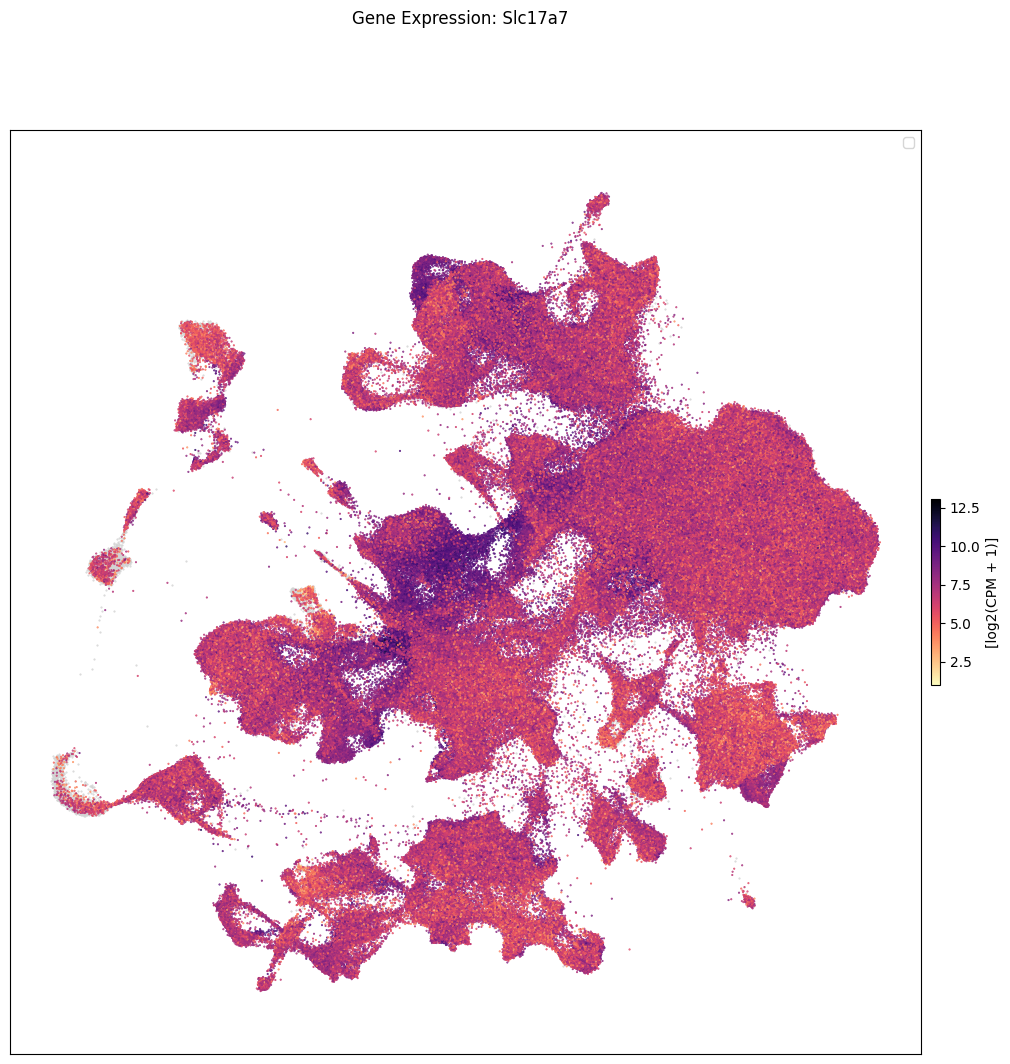

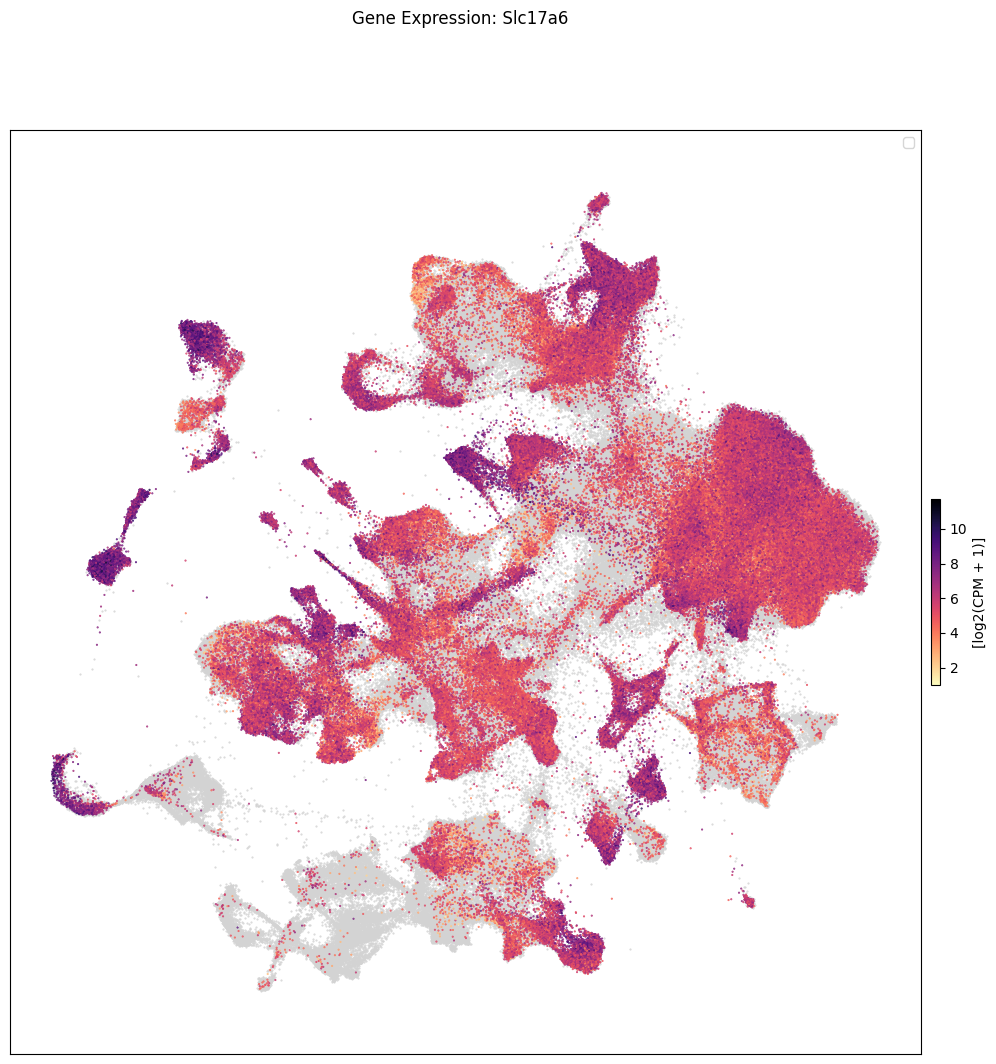

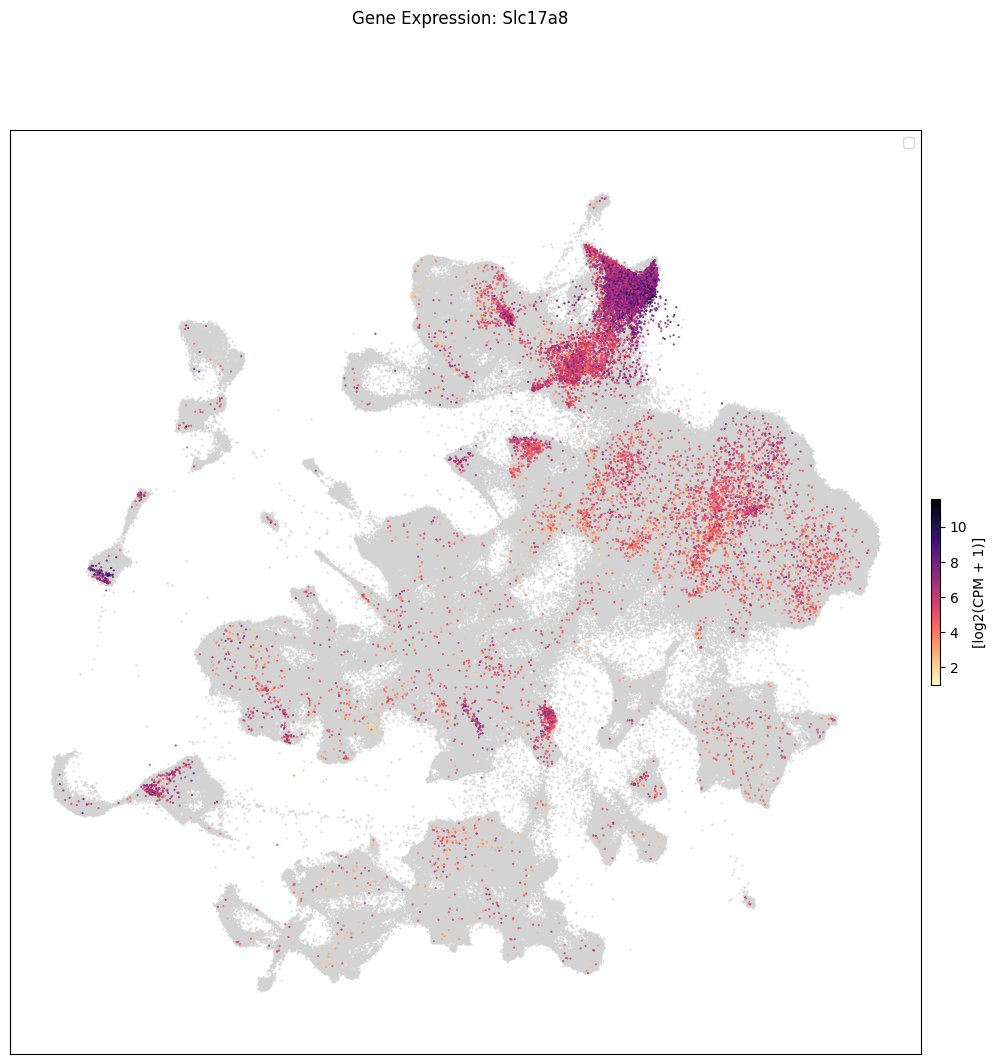

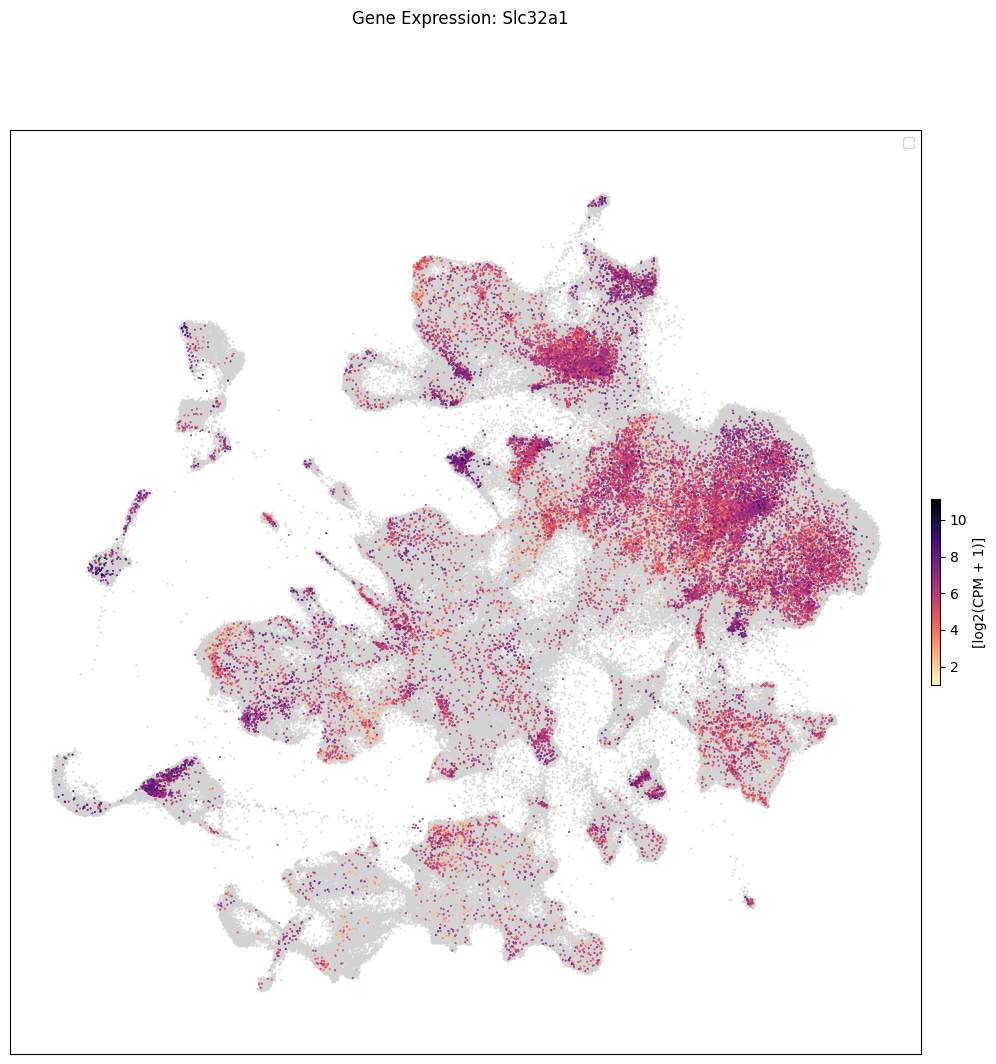

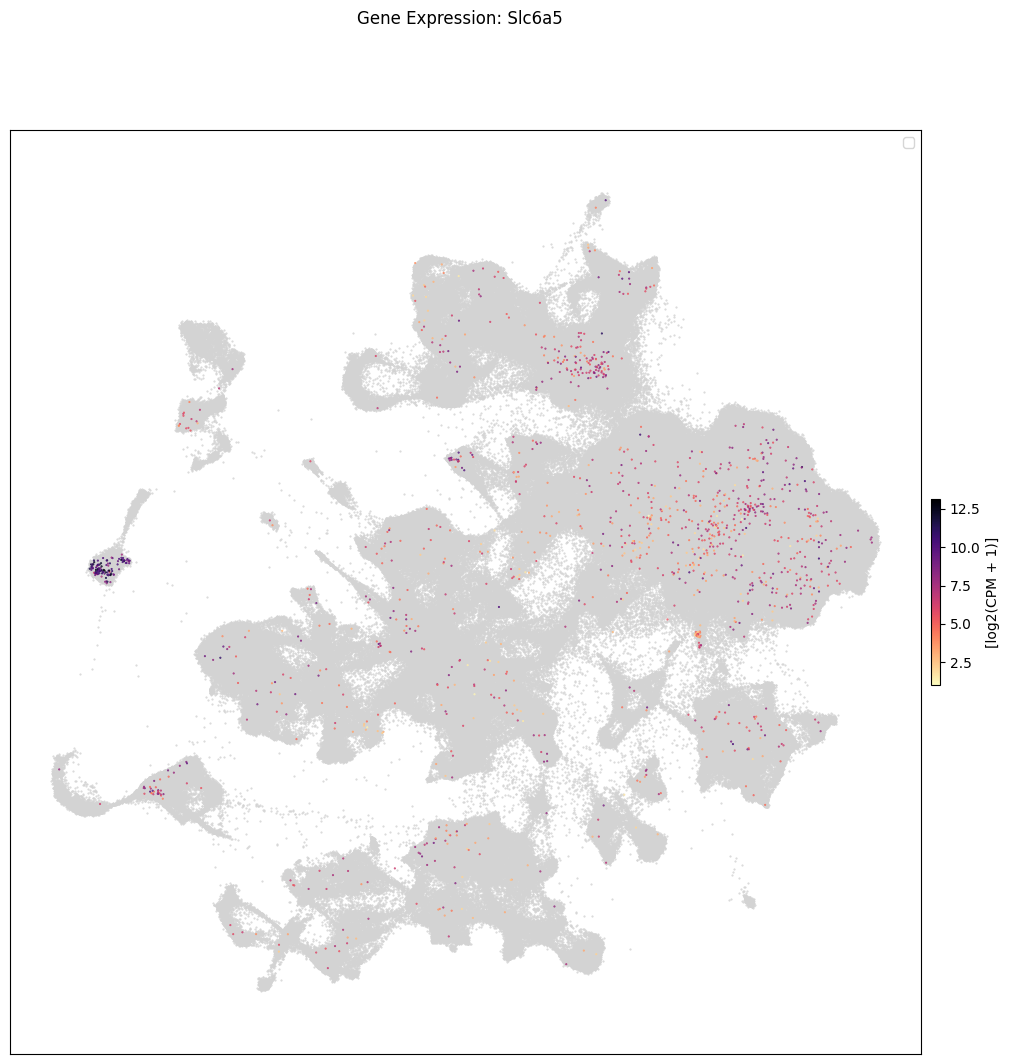

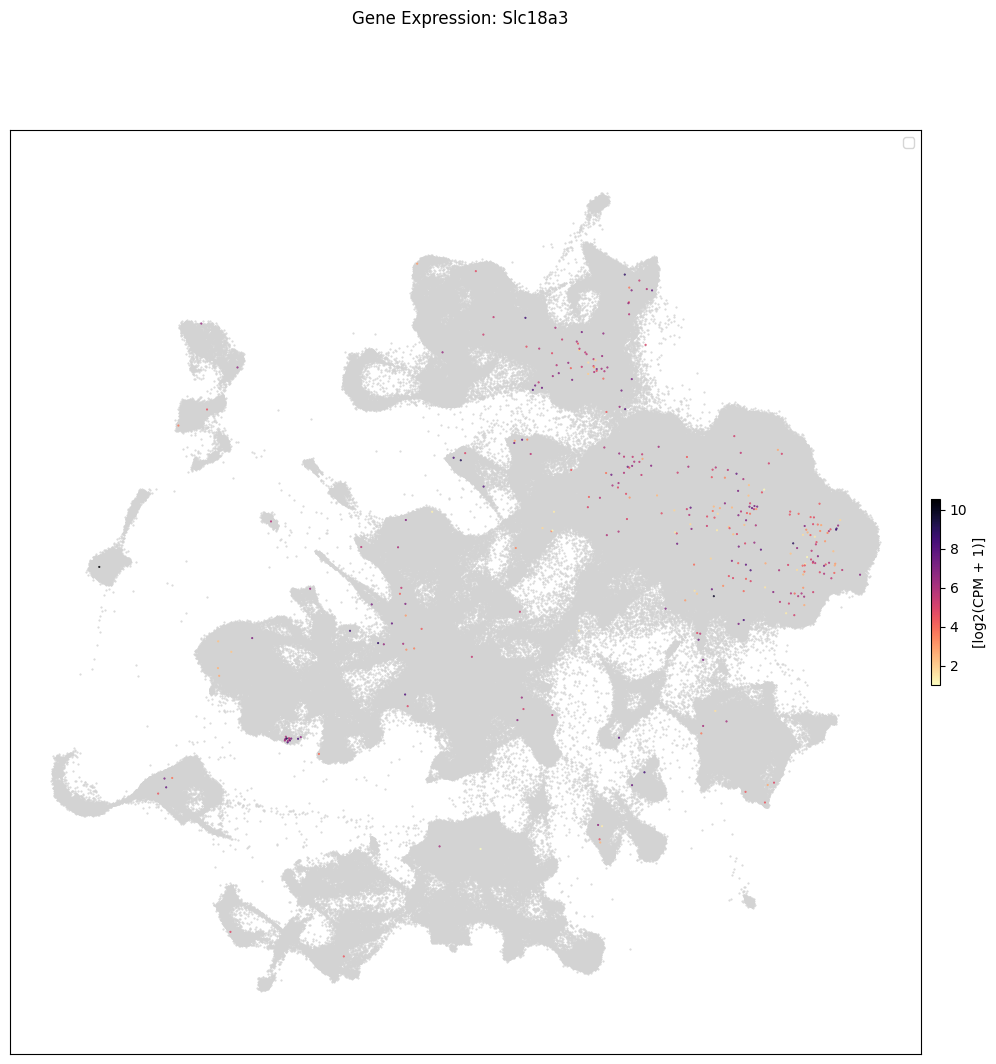

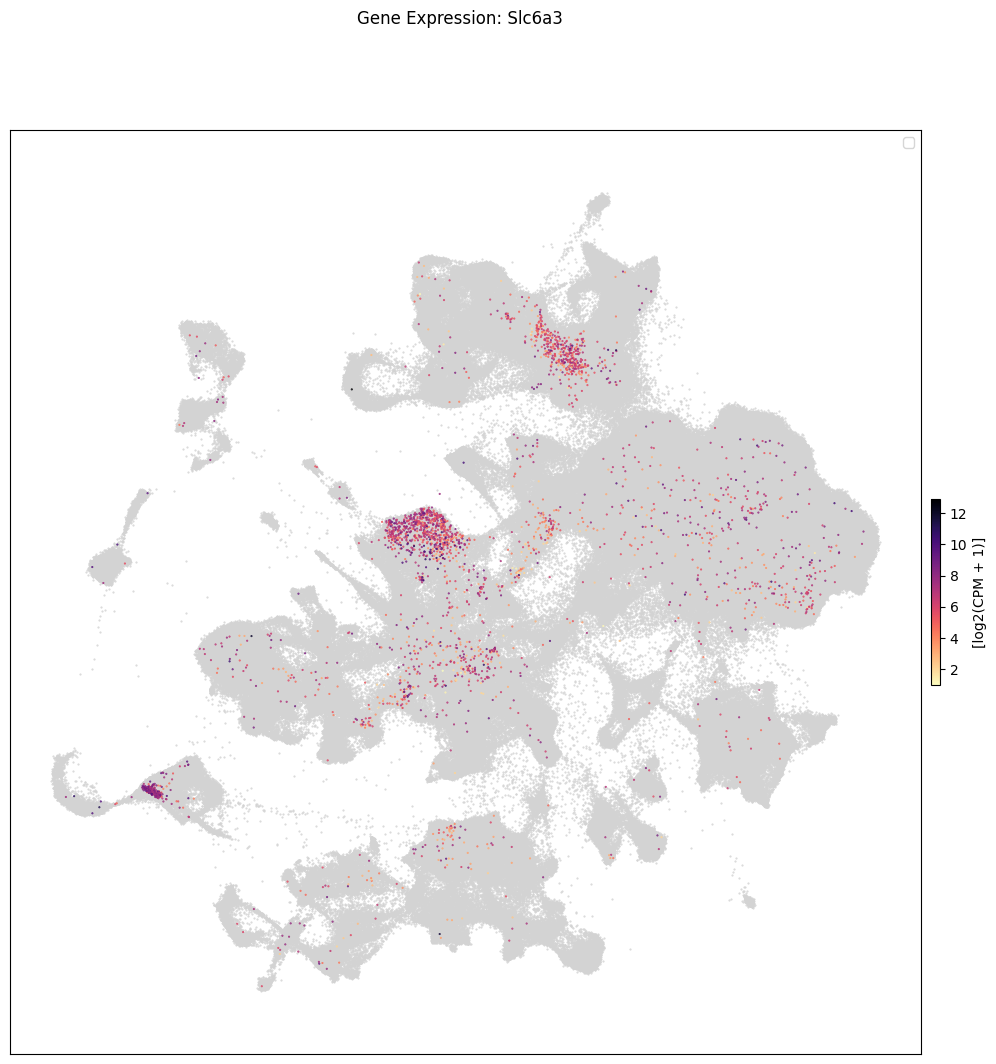

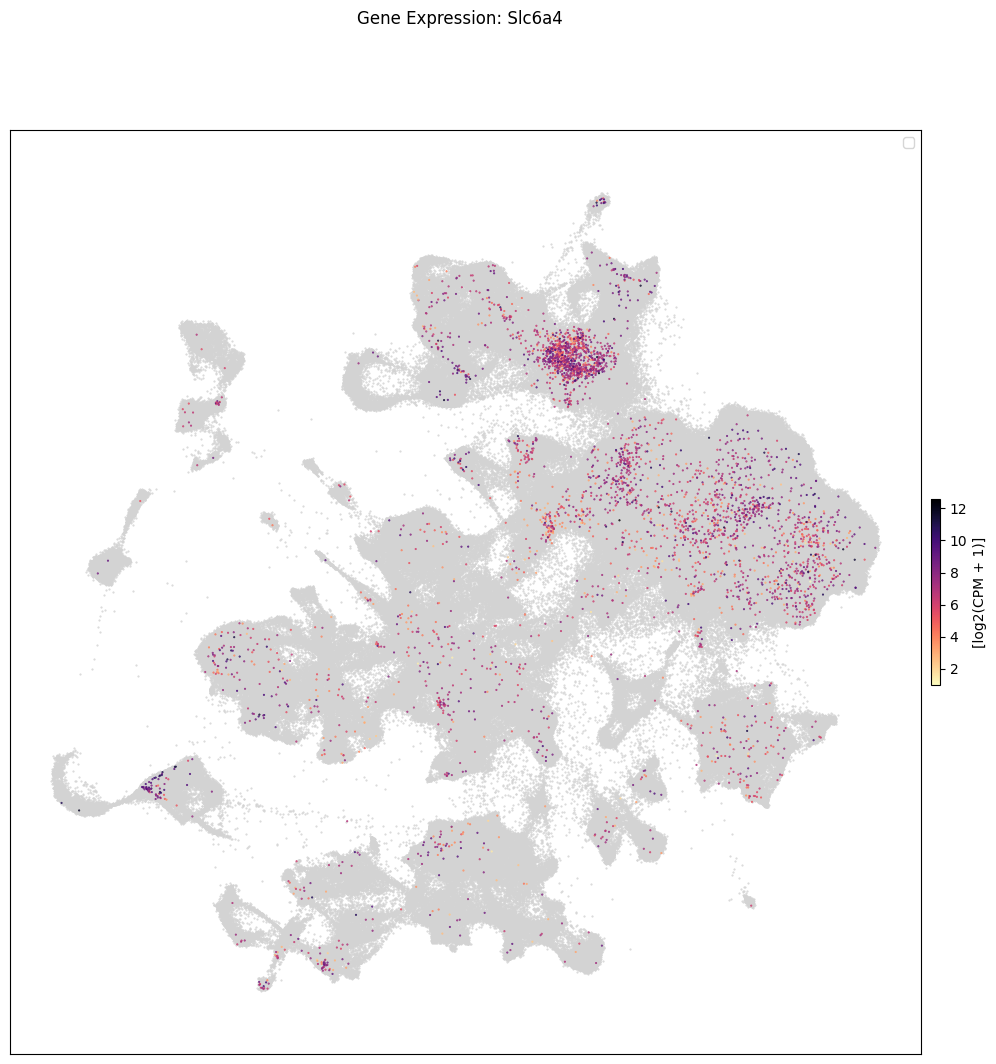

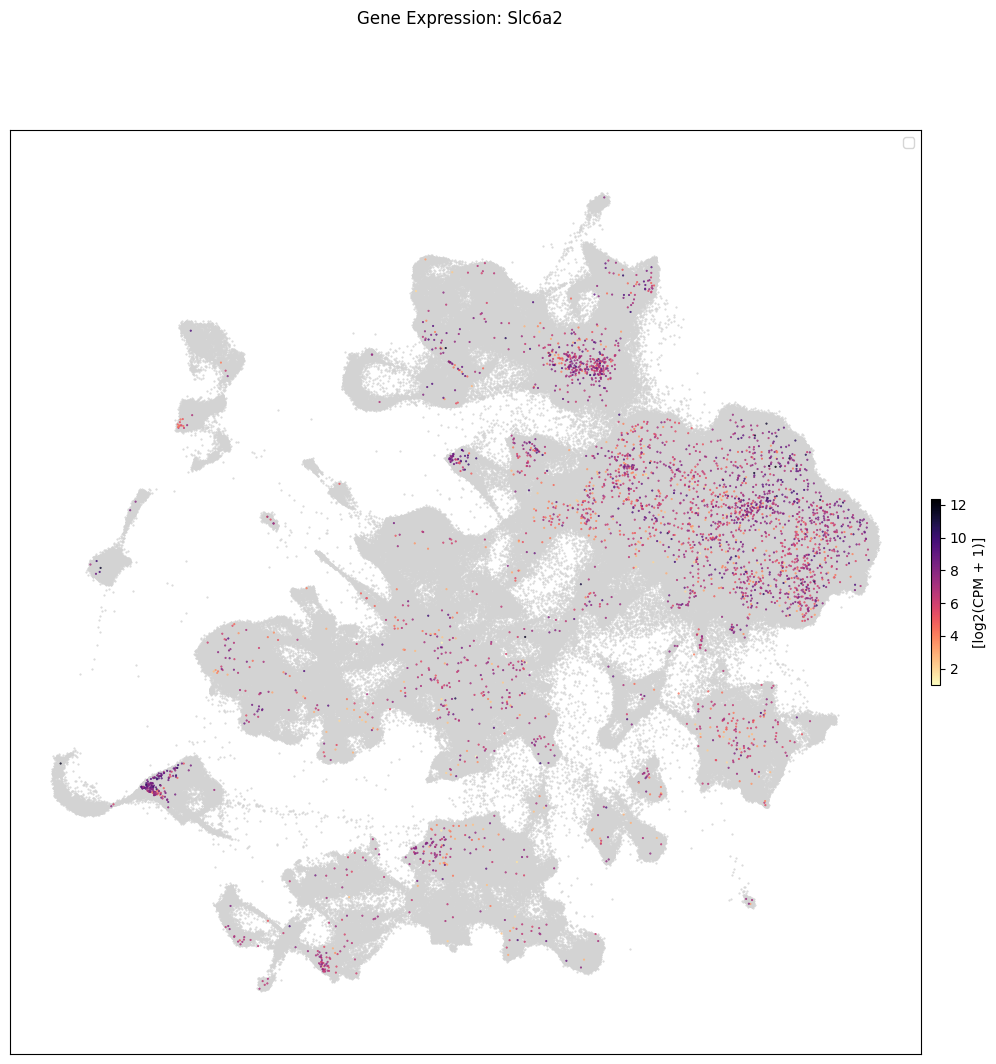

In [ ]:
for gene_name in gene_names:
    fig, ax = plot_umap(
        consensus_pal_glut_umap,
        feature=gene_name,
        cmap=plt.cm.magma_r,
        vmin=1,
        vmax=None,
        
    )
    fig.suptitle(f'Gene Expression: {gene_name}')
    plt.show()

Check out the previous exploration of the taxonomy and clustering annotations [here](https://alleninstitute.github.io/abc_atlas_access/notebooks/consensus_mouse_clustering_analysis_and_annotation.html). The notebooks for the 